<a href="https://colab.research.google.com/github/AIwithMallesh/pandas-date-cleaner/blob/main/pandas_date_cleaner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Messy Dates? No Problem: A Pandas Cleaning Adventure

Dates in data are like that one sock that always disappears—annoying and inconsistent. In this notebook, we'll:
- Load a sample dataset with event dates in wild formats.
- Spot the chaos (exploratory data analysis).
- Clean 'em up using `pd.to_datetime` magic.
- Validate and visualize (because who doesn't love a timeline?).
- Export the shiny result.

This is inspired by real-world pains, like scraping event calendars or merging CSVs from different sources.

Let's dive in!

In [3]:
# Standard imports—keeping it simple, no extras needed
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np  # Just in case for random data gen

# Set some pandas options for nicer output
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("All set! Pandas version:", pd.__version__)


All set! Pandas version: 2.2.2


In [ ]:
## Step 1: Whip Up Some Messy Data

#We'll create a fake events dataset. Imagine this came from a CSV export of a calendar app gone wrong—dates in DD/MM/YYYY, ISO, US month-day, even typos for fun.

In [4]:
# Let's make a bigger dataset to make it feel "real"—say 20 events
np.random.seed(42)  # For reproducibility, 'cause why not

events = ['Team Meeting', 'Client Pitch', 'Code Review', 'Lunch Break', 'Workshop',
          'Conference Call', 'Deadline', 'Brainstorm', 'Debug Session', 'Coffee Run',
          'Product Launch', 'Feedback Session', 'Training', 'Bug Hunt', 'Standup',
          'Retrospective', 'Sprint Planning', 'Demo Day', 'Hackathon', 'Wrap Party']

# Generate mixed-up dates—some good, some bad
date_formats = [
    '15/05/2023',  # DD/MM/YYYY
    '2023-06-10',  # ISO
    'July 4, 2023',  # Month DD, YYYY
    '10-Jun-23',   # DD-MMM-YY
    '2023/12/25',  # YYYY/MM/DD
    'Feb 29, 2024', # Invalid leap day? Nah, 2024 is leap
    'invalid date lol',  # Garbage
    '01-02-2023',  # Ambiguous MM/DD or DD/MM?
]

# Repeat and shuffle to make 20 entries
raw_dates = np.random.choice(date_formats, size=20, replace=True)
raw_dates = np.random.permutation(raw_dates)  # Shuffle for variety

# Pair with events
data_dict = {
    'event': np.random.choice(events, size=20, replace=True),
    'date_raw': raw_dates,
    'description': [f"Details for {e}" for e in np.random.choice(events, size=20, replace=True)]
}

df = pd.DataFrame(data_dict)

# Save to CSV for that "real data" feel— we'll load it back later if we want
df.to_csv('messy_events.csv', index=False)

print("Sample of the chaos:")
print(df.head(10))
print(f"\nShape: {df.shape}")
print(f"Date types: {df['date_raw'].dtype}")

Sample of the chaos:
              event          date_raw                  description
0           Standup        2023/12/25       Details for Brainstorm
1         Hackathon      July 4, 2023          Details for Standup
2  Feedback Session      July 4, 2023      Details for Code Review
3        Wrap Party  invalid date lol         Details for Bug Hunt
4       Code Review         10-Jun-23  Details for Sprint Planning
5          Workshop        2023/12/25      Details for Lunch Break
6         Hackathon        2023/12/25         Details for Demo Day
7          Deadline      July 4, 2023       Details for Brainstorm
8     Debug Session  invalid date lol      Details for Lunch Break
9          Deadline        01-02-2023     Details for Client Pitch

Shape: (20, 3)
Date types: object


In [5]:
## Step 2: EDA - What's Wrong Here?

#Quick peek: All dates are strings (object dtype). But look at those formats—pandas will choke without help.

In [6]:
# Basic info
print("Dataset Info:")
print(df.info())
print("\nUnique date formats (first 10):")
print(df['date_raw'].unique()[:10])

# Try a naive parse to see failures
df['date_naive'] = pd.to_datetime(df['date_raw'], errors='coerce')
failed_count = df['date_naive'].isna().sum()
print(f"\nNaive parse fails: {failed_count}/{len(df)} dates ({failed_count/len(df)*100:.1f}%)")

print("\nFailed examples:")
print(df[df['date_naive'].isna()][['event', 'date_raw']].head())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   event        20 non-null     object
 1   date_raw     20 non-null     object
 2   description  20 non-null     object
dtypes: object(3)
memory usage: 612.0+ bytes
None

Unique date formats (first 10):
['2023/12/25' 'July 4, 2023' 'invalid date lol' '10-Jun-23' '01-02-2023'
 '2023-06-10']

Naive parse fails: 16/20 dates (80.0%)

Failed examples:
              event          date_raw
1         Hackathon      July 4, 2023
2  Feedback Session      July 4, 2023
3        Wrap Party  invalid date lol
4       Code Review         10-Jun-23
7          Deadline      July 4, 2023


In [ ]:
## Step 3: Clean Those Dates!

#Key trick: `format='mixed'` in `to_datetime`. It auto-detects common formats. Add `dayfirst=True` for Euro-style slashes, and `errors='coerce'` to NaT the trash.

#We'll drop the raw col after, but keep it for now to compare.

In [7]:
# The hero line—tried without 'mixed' first, failed half, so added it
df['date_clean'] = pd.to_datetime(
    df['date_raw'],
    format='mixed',  # Handles the variety
    dayfirst=True,   # DD/MM over MM/DD
    errors='coerce'  # NaT for invalids
)

# Check success rate now
success_count = df['date_clean'].notna().sum()
print(f"Clean parse success: {success_count}/{len(df)} ({success_count/len(df)*100:.1f}%)")

print("\nBefore/After peek:")
print(df[['date_raw', 'date_clean']].head(10))

# Drop raw and rename for cleanliness
df = df.drop('date_raw', axis=1)
df = df.rename(columns={'date_clean': 'date'})

# Sort by date—'cause why not?
df = df.sort_values('date').reset_index(drop=True)

print("\nSorted & Cleaned DF:")
print(df.head())
print(f"\nNew dtype: {df['date'].dtype}")

Clean parse success: 16/20 (80.0%)

Before/After peek:
           date_raw date_clean
0        2023/12/25 2023-12-25
1      July 4, 2023 2023-07-04
2      July 4, 2023 2023-07-04
3  invalid date lol        NaT
4         10-Jun-23 2023-06-10
5        2023/12/25 2023-12-25
6        2023/12/25 2023-12-25
7      July 4, 2023 2023-07-04
8  invalid date lol        NaT
9        01-02-2023 2023-02-01

Sorted & Cleaned DF:
           event                   description date_naive       date
0       Deadline      Details for Client Pitch        NaT 2023-02-01
1    Lunch Break        Details for Coffee Run        NaT 2023-02-01
2  Debug Session  Details for Feedback Session        NaT 2023-02-01
3        Standup       Details for Lunch Break        NaT 2023-02-01
4    Code Review   Details for Sprint Planning        NaT 2023-06-10

New dtype: datetime64[ns]


In [ ]:
## Step 4: Validate – Did We Miss Anything?

#Count NaTs, maybe fill with a default or flag. For this project, we'll just drop 'em (real life: investigate source).

In [8]:
# Any stragglers?
nats = df[df['date'].isna()]
if len(nats) > 0:
    print(f"Still {len(nats)} NaT rows—dropping for now.")
    df = df.dropna(subset=['date'])
    print("Dropped. New shape:", df.shape)
else:
    print("All good! No NaTs left.")

# Quick sanity: Min/max dates
print(f"Date range: {df['date'].min()} to {df['date'].max()}")

Still 4 NaT rows—dropping for now.
Dropped. New shape: (16, 4)
Date range: 2023-02-01 00:00:00 to 2023-12-25 00:00:00


In [ ]:
## Step 5: Viz – Event Timeline

#Matplotlib for a simple Gantt-ish plot. Events on Y, dates on X. Fun way to see the flow.

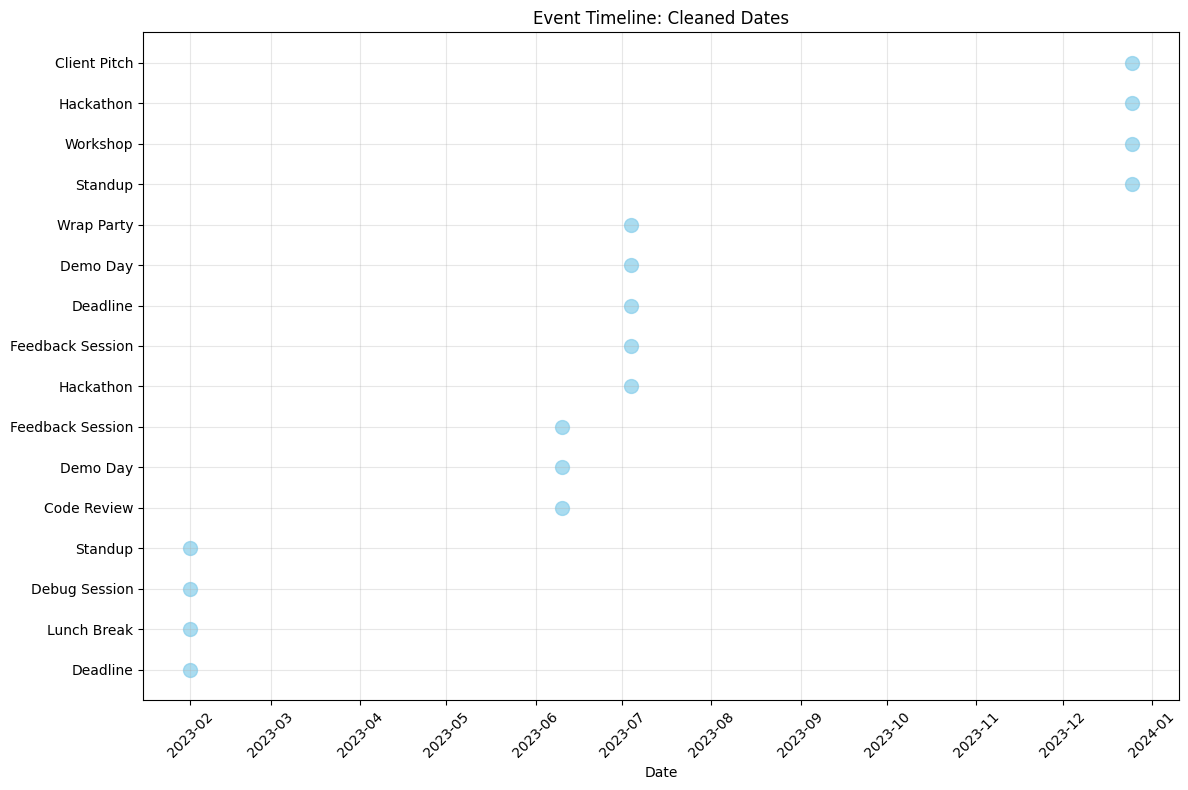

Plot saved as event_timeline.png


<Figure size 640x480 with 0 Axes>

In [9]:
# Basic timeline plot—tweaked colors 'cause defaults are meh
fig, ax = plt.subplots(figsize=(12, 8))

# Plot each event as a point (or bar if you want fancier)
for i, row in df.iterrows():
    ax.scatter(row['date'], i, s=100, alpha=0.7, color='skyblue', label=row['event'] if i == 0 else "")

# Labels and stuff
ax.set_yticks(range(len(df)))
ax.set_yticklabels(df['event'])
ax.set_xlabel('Date')
ax.set_title('Event Timeline: Cleaned Dates')
ax.grid(True, alpha=0.3)

# Rotate x for readability
plt.xticks(rotation=45)
plt.tight_layout()

# Show it— in Jupyter this pops up inline
plt.show()

# Save for Git/LinkedIn
plt.savefig('event_timeline.png', dpi=150, bbox_inches='tight')
print("Plot saved as event_timeline.png")

In [ ]:
## Step 6: Export & Next Steps

# Dump to CSV. In a real pipeline, you'd feed this to a DB or ML model.

# Ideas to extend:
# - Web scrape dates with BeautifulSoup.
# - Handle timezones with pytz.
# - Unit tests with pytest.

In [11]:
# Export cleaned data
df.to_csv('clean_events.csv', index=False)
print("Cleaned data saved to clean_events.csv")

print("\nFinal DF Summary:")
print(df.describe(include='all'))  # Quick stats



Cleaned data saved to clean_events.csv

Final DF Summary:
           event               description           date_naive  \
count         16                        16                    4   
unique        11                        11                  NaN   
top     Deadline  Details for Client Pitch                  NaN   
freq           2                         2                  NaN   
mean         NaN                       NaN  2023-12-25 00:00:00   
min          NaN                       NaN  2023-12-25 00:00:00   
25%          NaN                       NaN  2023-12-25 00:00:00   
50%          NaN                       NaN  2023-12-25 00:00:00   
75%          NaN                       NaN  2023-12-25 00:00:00   
max          NaN                       NaN  2023-12-25 00:00:00   

                       date  
count                    16  
unique                  NaN  
top                     NaN  
freq                    NaN  
mean    2023-07-04 18:00:00  
min     2023-02-01 00:00